In [1]:
from pathlib import Path
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

BASE_DIR = Path("..").resolve()
CLEAN_DIR = BASE_DIR / "data" / "processed" / "clean_480p"
OVERLAY_DIR = BASE_DIR / "data" / "processed" / "overlays"
OVERLAY_DIR.mkdir(exist_ok=True)

frames = sorted(glob.glob(str(CLEAN_DIR / "*.png")))
len(frames)


ModuleNotFoundError: No module named 'cv2'

In [ ]:
import torch

CHECKPOINT = BASE_DIR / "checkpoints" / "sam_vit_b_01ec64.pth"

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

sam = sam_model_registry["vit_b"](checkpoint=str(CHECKPOINT))
sam.to(device)  # Move model to GPU
predictor = SamPredictor(sam)

print("SAM loaded")

SAM loaded


In [5]:
def sam_segment(image_bgr):
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    predictor.set_image(img_rgb)

    h, w, _ = img_rgb.shape
    point = np.array([[w//2, h//2]])  # center point
    label = np.array([1])             # foreground

    masks, scores, _ = predictor.predict(
        point_coords=point,
        point_labels=label,
        multimask_output=True
    )
    return masks[np.argmax(scores)]


In [6]:
def overlay_mask(image_bgr, mask, color=(0, 255, 0), alpha=0.6):
    overlay = image_bgr.copy()
    overlay[mask] = color
    return cv2.addWeighted(overlay, alpha, image_bgr, 1 - alpha, 0)


In [ ]:
N = 600

for i, p in enumerate(frames[:N]):
    img = cv2.imread(p)
    mask = sam_segment(img)
    result = overlay_mask(img, mask)

    fname = os.path.basename(p)
    cv2.imwrite(str(OVERLAY_DIR / f"overlay_{fname}"), result)

    print(f"Processed {i+1}/{N}")


Processed 1/100
Processed 2/100
Processed 3/100
Processed 4/100
Processed 5/100
Processed 6/100
Processed 7/100
Processed 8/100
Processed 9/100
Processed 10/100
Processed 11/100
Processed 12/100
Processed 13/100
Processed 14/100
Processed 15/100
Processed 16/100
Processed 17/100
Processed 18/100
Processed 19/100
Processed 20/100
Processed 21/100
Processed 22/100
Processed 23/100
Processed 24/100
Processed 25/100
Processed 26/100
Processed 27/100
Processed 28/100
Processed 29/100
Processed 30/100
Processed 31/100
Processed 32/100
Processed 33/100
Processed 34/100
Processed 35/100
Processed 36/100
Processed 37/100
Processed 38/100
Processed 39/100
Processed 40/100
Processed 41/100
Processed 42/100
Processed 43/100
Processed 44/100
Processed 45/100
Processed 46/100
Processed 47/100
Processed 48/100
Processed 49/100
Processed 50/100
Processed 51/100
Processed 52/100
Processed 53/100
Processed 54/100
Processed 55/100
Processed 56/100
Processed 57/100
Processed 58/100
Processed 59/100
Proces

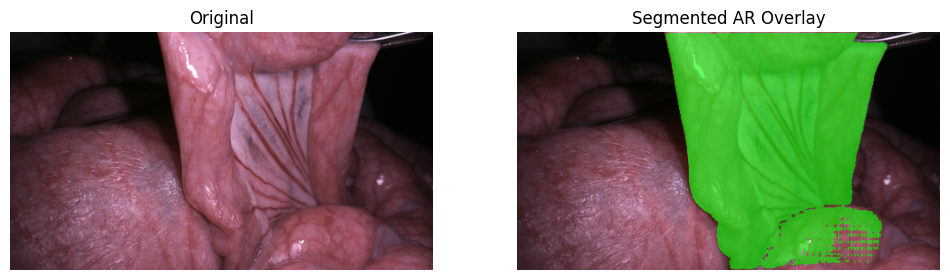

In [8]:
sample = frames[0]
overlay_file = OVERLAY_DIR / ("overlay_" + os.path.basename(sample))

orig = cv2.cvtColor(cv2.imread(sample), cv2.COLOR_BGR2RGB)
ovl  = cv2.cvtColor(cv2.imread(str(overlay_file)), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(orig); plt.title("Original"); plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ovl); plt.title("Segmented AR Overlay"); plt.axis("off")
plt.show()